In [1]:
!pip install datasets keras-tuner contractions pyspellchecker langdetect deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=6a253ccb64f3a4ab798bb21125bc004b6cdca1310167a7fc39c0f45c07b92fee
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import numpy as np
import torch
import torch.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, Layer, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from deep_translator import MyMemoryTranslator
from langdetect import detect
import spacy
import contractions
import nltk
from spellchecker import SpellChecker
import random

# Set a seed value
seed_value = 42

random.seed(seed_value)
# For NumPy
np.random.seed(seed_value)

# For TensorFlow
tf.random.set_seed(seed_value)

# For PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset Preparation

In [3]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")

# Split the dataset into training, validation, and test sets
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

# Generate Word Embeddings

In [4]:
# Download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-09 11:17:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-09 11:17:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-09 11:17:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

# Data Exploration & Preprocessing

In [5]:
train_text = train_dataset['text']

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

# Number of unique words in the train dataset
vocab_size = len(tokenizer.word_index)
print("Vocabulary size of train data:", vocab_size)

Vocabulary size of train data: 17451


In [6]:
def load_glove_vocab(filepath):
    glove_vocab = set()
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            glove_vocab.add(word)
    return glove_vocab

# Load Glove words into a set
glove_vocab = load_glove_vocab('glove.6B.300d.txt')

# Identify OOV words (Words appeared in training data but not in the GloVe dictionary)
oov_words = []
for word in tokenizer.word_index:
  if word not in glove_vocab:
    oov_words.append(word)

# Print OOV words
print("Size of Glove Vocabulary:", len(glove_vocab))
print("Out-Of-Vocabulary Words:", oov_words)
print("Number of OOV words:", len(oov_words))

Size of Glove Vocabulary: 400000
Out-Of-Vocabulary Words: ["it's", "doesn't", "there's", "that's", "isn't", "don't", "can't", "film's", "you're", "you'll", "he's", "movie's", "won't", "what's", "you've", "i'm", "didn't", "they're", "year's", '\x96', "you'd", "aren't", "i've", "we've", "couldn't", "she's", "man's", "we're", "wasn't", "i'd", '\x97', "who's", "director's", "haven't", "here's", "story's", "characters'", "wouldn't", "i'll", "'the", "woman's", "hasn't", "world's", "filmmaker's", "children's", "moore's", "one's", "soderbergh's", "america's", "disney's", "shouldn't", "ain't", "character's", "cinema's", "women's", "cho's", "hoffman's", "kids'", "today's", "amy's", "wilde's", "life's", "they'll", "emperor's", "sandler's", "scorsese's", "allen's", "it'll", "filmmakers'", 'cletis', "carvey's", "let's", "stevenson's", 'waydowntown', "polanski's", "he'd", "weren't", "lee's", "everyone's", "parker's", "woo's", "'i", "greene's", "2002's", "actor's", "bullock's", "writer's", "shakespea

## Cleaning Training Text

In [7]:
def expand_contractions(text):
    return contractions.fix(text)

In [8]:
def re_manip(text):
    #remove apostrophe and punctuations
    text = re.sub(r"'\S*", "", text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #remove numbers
    text = re.sub(r'\b\d+(st|nd|rd|th)?\b', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
### INTERMEDIARY STEP TO NOT OVERUSE TRANSLATION API
cleaned_train_text = [re_manip(expand_contractions(text)) for text in train_text]

tokenizer = Tokenizer(oov_token='<UNK>')  # <UNK> for unseen words
tokenizer.fit_on_texts(cleaned_train_text)

# Identify OOV words (Words appeared in training data but not in the GloVe dictionary)
oov_words = []
for word in tokenizer.word_index:
  if word not in glove_vocab:
    oov_words.append(word)

In [10]:
language_locale_map = {
    "es": "es-ES",
    "fr": "fr-FR",
    "de": "de-DE",
    "it": "it-IT",
    "pt": "pt-PT",
    "ru": "ru-RU",
    "zh": "zh-CN",
    "ja": "ja-JP",
    "ko": "ko-KR",
    "ar": "ar-SA"
}

In [11]:
spell = SpellChecker(distance=3)
def correct_and_translate(word):
    spell.distance = 3
    corrected_word = spell.correction(word) or word
    try:
        lang = detect(corrected_word)
        if lang in language_locale_map and lang != 'en':
            source_locale = language_locale_map[lang]
            translator = MyMemoryTranslator(source=source_locale, target='en-US')
            corrected_word = translator.translate(corrected_word)
    except Exception as e:
        print(f"Error translating word '{corrected_word}': {e}")
    
    return corrected_word

In [12]:
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker(distance=3)
def lemmatize_with_handling(text, oov_words):
    doc = nlp(text)
    lemmatized_words = []
    for token in doc:
        if token.text in oov_words:
            lemmatized_words.append(correct_and_translate(token.text))
        else:
            spell.distance = 2
            lemma = token.lemma_
            if token.lemma_ not in glove_vocab:
                lemma = spell.correction(lemma) or lemma
            lemmatized_words.append(lemma)
    return " ".join(lemmatized_words)

cleaned_train_text = [lemmatize_with_handling(text, oov_words) for text in cleaned_train_text]

print("Before:", train_text[0])
print("After:", cleaned_train_text[0])

Before: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
After: the rock be destine to be the century new conan and that he be go to make a splash even great than arnold schwarzenegger jean claud van damme or steven segal


In [13]:
### FUNCTION PURELY FOR TEST/VAL DATA
def clean_words(texts):
    cleaned_text = [re_manip(expand_contractions(text)) for text in texts]
    tokenizer.fit_on_texts(cleaned_text)  
    # Identify OOV words (Words appeared in training data but not in the GloVe dictionary)
    oov_word = []
    for word in tokenizer.word_index:
      if word not in glove_vocab:
        oov_word.append(word)
    finalised_text = [lemmatize_with_handling(text, oov_word) for text in cleaned_text]
    return finalised_text

In [14]:
#Clean test/validation sets
test_text = test_dataset['text']
val_text = validation_dataset['text']
cleaned_test_text = clean_words(test_text)
cleaned_val_text = clean_words(val_text)

## Assigning 'UNK' Label on Cleaned Training Text

In [15]:
# Initialise the tokeniser
tokenizer = Tokenizer(oov_token='<UNK>')  # <UNK> for unseen words
tokenizer.fit_on_texts(cleaned_train_text)

# Identify OOV words (Words appeared in training data but not in the GloVe dictionary)
oov_words = []
for word in tokenizer.word_index:
  if word not in glove_vocab:
    oov_words.append(word)

# Print OOV words
print("Out-of-vocabulary words:", oov_words)
print("Number of OOV words:", len(oov_words))

Out-of-vocabulary words: ['<UNK>', 'exhilarate', 'engross', 'moviemake', 'stylize', 'unclinch', 'windtalker', 'clockstopper', 'enthral', 'waydowntown', 'ozpetek', 'everlaste', 'spellbind', 'kosashvili', 'tambac', 'swinge', 'feardotcom', 'overstuff', 'deprave', 'watstein', 'appal', 'breathtake', 'throe', 'rollick', 'tatter', 'runteldat', 'misconceive', 'cheerly', 'janklowicz', 'frissons', 'infatuate', 'roteirista', 'stupefy', 'groundbreake', 'cliffsnote', 'wertmull', 'wisegirls', 'enrapturing', 'originalidad', 'overpraise', 'syncopate', 'obviation', 'gorefests', 'makmalbaf', 'shapelessly', 'mullinski', 'narcotizing', 'sparklingly', 'dreyfu', 'nonthreatene', 'dominatrixes', 'denlopp', 'sappier', 'sorprenderá', 'sarcastic\xa0', 'powaqqatsi', 'kaputschnik', 'monkeyfun', 'bierbichler', 'unindicte', 'datedness', 'inhospitality', 'hastier', 'existência', 'inquestionável', 'hotdogging', 'sogginess', 'stuffiest', 'limewater', 'muckrake', 'premiss', 'culminant', 'desfecho', 'lentamente', 'soarin

# Model Training BiLSTM

In [16]:
embedding_dim = 300  # The dimension of GloVe embedding
vocab_size = len(tokenizer.word_index)
max_seq_len = 100

In [17]:
# Convert texts to sequences (words to the word index in tokenizer)
train_sequences = tokenizer.texts_to_sequences(cleaned_train_text)

# Pad the sequences (ensure they are all the same length)
max_seq_len = 100
tokenizer.word_index['<PAD>'] = 0
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding='post', value=tokenizer.word_index['<PAD>'])

print("Before:", train_sequences[0])
print("After:", list(train_padded[0]))

Before: [2, 579, 3, 2602, 7, 3, 2, 748, 98, 4252, 5, 10, 61, 3, 71, 7, 25, 4, 2291, 60, 113, 34, 1349, 1854, 1855, 7481, 1439, 5371, 41, 834, 7482]
After: [2, 579, 3, 2602, 7, 3, 2, 748, 98, 4252, 5, 10, 61, 3, 71, 7, 25, 4, 2291, 60, 113, 34, 1349, 1854, 1855, 7481, 1439, 5371, 41, 834, 7482, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
# Prepare inputs for model
# Convert validation and test texts to sequences
val_sequences = tokenizer.texts_to_sequences(cleaned_val_text)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_text)

# Pad sequences
val_padded = pad_sequences(val_sequences, maxlen=max_seq_len, padding='post', value=tokenizer.word_index['<PAD>'])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post', value=tokenizer.word_index['<PAD>'])

# Labels
train_labels = np.array(train_dataset['label'])
val_labels = np.array(validation_dataset['label'])
test_labels = np.array(test_dataset['label'])

# Creating Embedding Matrix

In [19]:
# word_index refers to the vocab in training data?
print(tokenizer.word_index)
print(len(tokenizer.word_index))

{'<UNK>': 1, 'the': 2, 'be': 3, 'a': 4, 'and': 5, 'of': 6, 'to': 7, 'it': 8, 'in': 9, 'that': 10, 'film': 11, 'not': 12, 'as': 13, 'but': 14, 'have': 15, 'movie': 16, 'with': 17, 'this': 18, 'for': 19, 'an': 20, 'its': 21, 'you': 22, 'on': 23, 'do': 24, 'make': 25, 'by': 26, 'one': 27, 'like': 28, 'about': 29, 'more': 30, 'i': 31, 'at': 32, 'from': 33, 'than': 34, 'all': 35, 'his': 36, 'good': 37, 'so': 38, 'will': 39, 'well': 40, 'or': 41, 'if': 42, 'story': 43, 'we': 44, 'character': 45, 'can': 46, 'what': 47, 'they': 48, 'time': 49, 'there': 50, 'who': 51, 'just': 52, 'too': 53, 'out': 54, 'up': 55, 'into': 56, 'comedy': 57, 'no': 58, 'most': 59, 'even': 60, 'he': 61, 'much': 62, 'work': 63, 'see': 64, 'get': 65, 'bad': 66, 'performance': 67, 'some': 68, 'director': 69, 'way': 70, 'go': 71, 'feel': 72, 'would': 73, 'only': 74, 'funny': 75, 'look': 76, 'life': 77, 'their': 78, 'little': 79, 'take': 80, 'love': 81, 'your': 82, 'very': 83, 'enough': 84, 'when': 85, 'come': 86, 'never':

In [20]:
def create_vector_matrix(filepath, word_index, embedding_dim):
    # Calculate the size of the vocabulary (including UNK token)
    vocab_size = len(word_index)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Load GloVe vectors from the file
    glove_embeddings = {}
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            glove_embeddings[word] = np.array(vector, dtype=np.float32)

    # Create the embedding matrix
    for word, idx in word_index.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Set the embedding to zero if word is OOV (including <UNK>)
            embedding_matrix[idx] = np.zeros(embedding_dim)


    return torch.tensor(embedding_matrix, dtype=torch.float32)


# Example usage with GloVe 100-dimensional embeddings
embedding_dim = 300
embedding_matrix = create_vector_matrix('glove.6B.300d.txt', tokenizer.word_index, embedding_dim)


# No. of rows should be equal to vocab size, no. of columns should be equal to vector dimension
print("Embedding Matrix Shape=> ", embedding_matrix.shape)

# Print the dense vector for the UNK token
unk_idx = tokenizer.word_index["<UNK>"]
print("Dense vector for UNK token is => ", embedding_matrix[unk_idx])

Embedding Matrix Shape=>  torch.Size([13256, 300])
Dense vector for UNK token is =>  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [45]:
model = Sequential()
vocab_size = len(tokenizer.word_index)
# Add the Embedding layer with GloVe weights and input shape
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_shape=(max_seq_len,),
                    weights=[embedding_matrix],
                    trainable=True))  # Set trainable=False to freeze GloVe weights, but we are updating the word embeddings, hence trainable= True

# Add a Bidirectional LSTM layer (2 layers currently)
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dropout(0.3))

# Add a Dense layer for classification
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.fit(train_padded, train_labels, validation_data=(val_padded, val_labels),
          epochs=10, batch_size=32, callbacks=[early_stopping])

loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

predictions = model.predict(test_padded)
predicted_classes = (predictions > 0.5).astype("int32")

for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, Actual: {test_labels[i]}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 300)       │     3,976,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100, 256)       │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,584,609 (17.49 MB)

 Trainable params: 4,584,609 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6515 - loss: 0.6124 - val_accuracy: 0.7664 - val_loss: 0.4744
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8285 - loss: 0.3913 - val_accuracy: 0.7871 - val_loss: 0.5159
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9073 - loss: 0.2364 - val_accuracy: 0.7730 - val_loss: 0.7112
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9556 - loss: 0.1277 - val_accuracy: 0.7711 - val_loss: 0.9428
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9793 - loss: 0.0608 - val_accuracy: 0.7702 - val_loss: 1.0951
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9899 - loss: 0.0360 - val_accuracy: 0.7683 - val_loss: 1.2249
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9938 - loss: 0.0192 - val_accuracy: 0.7711 - val_loss: 1.4482
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7919 - loss: 0.4792
Test Loss: 0.4778068065

In [46]:
print(f"Test Loss: {loss}, Test Accuracy: {accuracy  * 100:.2f}%")

Test Loss: 0.47780680656433105, Test Accuracy: 81.71%


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


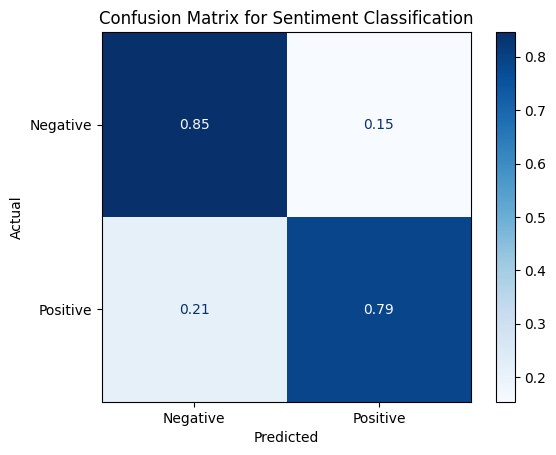

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_padded)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_labels.flatten()

class_labels = ["Negative", "Positive"]
 
cm = confusion_matrix(true_classes, predicted_classes, labels=[0, 1])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Sentiment Classification")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_padded)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_labels.flatten()

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=['Negative', 'Positive'])
print(report)

# Hyperparameter Tuning

In [25]:
!pip install keras-tuner
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [35]:
vocab_size = len(tokenizer.word_index)
# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Embedding layer (fixed with GloVe weights)
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_seq_len,
                        weights=[embedding_matrix],
                        trainable=True))

    # Add a Dropout layer after the embedding
    model.add(Dropout(hp.Choice('dropout_rate_embedding', values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    # Add a variable number of Bidirectional LSTM layers
    num_layers = hp.Int('num_bilstm_layers', min_value=1, max_value=3)  # Number of BiLSTM layers
    for i in range(num_layers):
      model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=128, max_value=512, step=64),
                                   return_sequences=(i != num_layers - 1))))



    # Add a Dense layer with ReLU activation
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'))

    # Add a Dropout layer after the Dense layer
    model.add(Dropout(hp.Choice('dropout_rate_dense', values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    # Output layer (sigmoid for binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperband tuner
tuner = kt.Hyperband(
    build_model,  # The model-building function
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='bilstm_tuning',
    project_name='bilstm_tuning'
)

# Define an early stopping callback
early_stopper = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)


# Perform the search for best hyperparameters
tuner.search(train_padded, train_labels,
             epochs=50,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[32, 64, 128]),
             validation_data=(val_padded, val_labels),
             callbacks=[early_stopper])

Reloading Tuner from bilstm_tuning/bilstm_tuning/tuner0.json


In [36]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Dropout Rate (Embedding): {best_hps.get('dropout_rate_embedding')}")
print(f"Dropout Rate (Dense Layer): {best_hps.get('dropout_rate_dense')}")
print(f"Number of LSTM Layers: {best_hps.get('num_bilstm_layers')}")
print(f"Units per LSTM Layer: {best_hps.get('lstm_units')}")
print(f"Dense Layer Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")


Best Hyperparameters:
Dropout Rate (Embedding): 0.4
Dropout Rate (Dense Layer): 0.5
Number of LSTM Layers: 1
Units per LSTM Layer: 320
Dense Layer Units: 192
Learning Rate: 0.001
Batch Size: 64


In [39]:
# Get the best hyperparameters setup
best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Define an early stopping callback
early_stopper = EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True)

# Train the best model on the training data
history = best_model.fit(train_padded, train_labels,
                         epochs=20,
                         validation_data=(val_padded, val_labels),
                         batch_size=best_hps.get('batch_size'),
                         shuffle=True, callbacks = [early_stopper])

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions and a classification report
predictions = best_model.predict(test_padded)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_labels.flatten()

report = classification_report(true_classes, predicted_classes, target_names=['Negative', 'Positive'])
print(report)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6178 - loss: 0.6343 - val_accuracy: 0.7533 - val_loss: 0.5102
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7808 - loss: 0.4621 - val_accuracy: 0.7758 - val_loss: 0.4575
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8448 - loss: 0.3551 - val_accuracy: 0.7805 - val_loss: 0.5043
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8896 - loss: 0.2622 - val_accuracy: 0.7692 - val_loss: 0.5421
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9199 - loss: 0.1922 - val_accuracy: 0.7805 - val_loss: 0.6344
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9406 - loss: 0.1480 - val_accuracy: 0.7880 - val_loss: 0.7993
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9581 - loss: 0.1061 - val_accuracy: 0.7842 - val_loss: 0.8642
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9699 - loss: 0.0765 - val_accuracy: 0.781